In [1]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to determine if the first hurdle is cleared
def is_hurdle_cleared(knee, hurdle_height):
    """
    Determines if the first hurdle is cleared by analyzing the knee position.
    The knee should be above a defined hurdle height.
    """
    _, knee_y = knee
    return knee_y < hurdle_height  # Lower y-value means higher in the frame

# Paths for the stage 2 videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/hurdling/stages/stage2/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/hurdling/stages/stage2/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

# Define a hurdle height threshold (y-axis, normalized value)
hurdle_height_threshold = 0.5  # Adjust based on video analysis

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video
        frame_count = 0
        hurdle_cleared = False

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract knee keypoints for hurdle analysis
                right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x,
                              landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y]
                left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]

                # Check if either knee has cleared the hurdle
                if is_hurdle_cleared(right_knee, hurdle_height_threshold) or is_hurdle_cleared(left_knee, hurdle_height_threshold):
                    hurdle_cleared = True

                # Store data for this frame
                keypoints_data.append({
                    "frame": frame_count,
                    "right_knee": right_knee,
                    "left_knee": left_knee
                })

        # Release the video
        cap.release()

        # Save keypoints and hurdle clearance status to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump({"hurdle_cleared": hurdle_cleared, "keypoints": keypoints_data}, json_file, indent=4)

print("Hurdle clearance analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737656957.036083 10178720 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1737656957.092297 10178978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737656957.103368 10178986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737656957.116049 10178980 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Hurdle clearance analysis complete! JSON files saved in 'keypoints' folder.


In [3]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for hurdle clearance analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/hurdling/stages/stage2/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        with open(file_path, "r") as f:
            data = json.load(f)

        # Extract hurdle clearance indicator from the JSON
        hurdle_cleared = int(data.get("hurdle_cleared", 0))  # 1 if cleared, 0 if not

        # Store the hurdle clearance status
        sequences.append([hurdle_cleared])

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue
        
        labels.append(label)

# Pad sequences to ensure uniform input shape
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

Loaded 16 sequences with labels.


In [4]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 80


In [5]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Debug shape
print("X_train original shape:", X_train.shape)
print("X_val original shape:", X_val.shape)

# Determine the correct reshape dimensions
num_samples, total_timesteps = X_train.shape
num_features = 1  # Adjust based on feature count

X_train = X_train.reshape((num_samples, total_timesteps, num_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], num_features))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

X_train original shape: (61, 1)
X_val original shape: (19, 1)
Training samples: 61, Validation samples: 19


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,  # You can adjust based on convergence
    batch_size=16,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.5148 - mae: 0.5187 - val_loss: 0.4527 - val_mae: 0.4749
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5039 - mae: 0.5313 - val_loss: 0.4274 - val_mae: 0.4762
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3690 - mae: 0.4225 - val_loss: 0.4001 - val_mae: 0.4779
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4432 - mae: 0.5265 - val_loss: 0.3693 - val_mae: 0.4797
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3852 - mae: 0.5021 - val_loss: 0.3365 - val_mae: 0.4818
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3504 - mae: 0.5040 - val_loss: 0.3026 - val_mae: 0.4839
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2693 - mae: 0.4550 - val_loss: 0.2729 - val_mae: 0.4855
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2943 - mae: 0.5110 - val_loss: 0.2512 - val_mae: 0.4870
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2548 - mae:

In [21]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.1936, Validation MAE: 0.4016


In [22]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Predicted: 0.46, Actual: 0.00
Predicted: 0.46, Actual: 0.00
Predicted: 0.41, Actual: 1.00
Predicted: 0.46, Actual: 0.00
Predicted: 0.46, Actual: 0.00
Predicted: 0.46, Actual: 0.00
Predicted: 0.99, Actual: 1.00
Predicted: 0.99, Actual: 1.00
Predicted: 0.46, Actual: 0.00
Predicted: 0.49, Actual: 1.00
Predicted: 0.46, Actual: 0.00
Predicted: 0.46, Actual: 0.00
Predicted: 0.72, Actual: 1.00
Predicted: 0.46, Actual: 1.00
Predicted: 0.45, Actual: 1.00
Predicted: 0.46, Actual: 0.00
Predicted: 0.98, Actual: 1.00
Predicted: 0.46, Actual: 0.00
Predicted: 0.46, Actual: 1.00


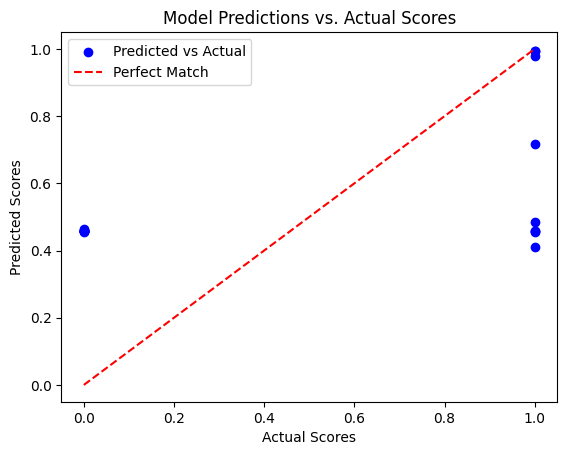

In [23]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [24]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the first hurdle is cleared
def is_hurdle_cleared(lead_leg, trail_leg, hurdle_height):
    """
    Determines if the first hurdle is cleared by checking if both legs move above a given height.
    """
    lead_leg_y = lead_leg[1]
    trail_leg_y = trail_leg[1]

    # Both legs must rise above the hurdle height threshold
    return lead_leg_y < hurdle_height and trail_leg_y < hurdle_height

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/hurdling/stages/stage2/test_videos/1_user9.mp4"

# Extract keypoints for the new video
hurdle_height_threshold = 0.5  # Adjust based on the expected height in normalized coordinates
hurdle_cleared = False

cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract relevant keypoints for hurdle analysis
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]

        # Check if the hurdle is cleared
        if is_hurdle_cleared(right_knee, left_knee, hurdle_height_threshold):
            hurdle_cleared = True

cap.release()

# Convert hurdle cleared status to binary value for model input
hurdle_cleared_value = 1 if hurdle_cleared else 0

print(f"First Hurdle Cleared: {hurdle_cleared_value}")

# Prepare data for model prediction
new_keypoints_padded = pad_sequences([[hurdle_cleared_value]], 
                                     maxlen=X_train.shape[1], 
                                     padding='post', dtype='float32')

# Reshape to match model input (samples, timesteps, features)
new_keypoints_padded = new_keypoints_padded.reshape((new_keypoints_padded.shape[0], new_keypoints_padded.shape[1], 1))

# Predict score for the new video
predicted_score = model.predict(new_keypoints_padded)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")

I0000 00:00:1737657199.374971 10178720 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737657199.434754 10313581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737657199.445036 10313579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


First Hurdle Cleared: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Predicted Score: 0.99


In [25]:
print(X_train.shape[1])

1


In [26]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.7:
        return 1.0
    elif prediction >= 0.5:
        return 0.5
    else:
        return 0.0

In [33]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 1.0


In [34]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [35]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [36]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Classification Accuracy: 0.74


In [37]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/hurdling/stages/stage2/models/hurdles_stage2.keras")